# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [2]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [3]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [4]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [5]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [6]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [7]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [8]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [10]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8L, 27L)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [11]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]], dtype=int64)

In [12]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [13]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [14]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [15]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [16]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

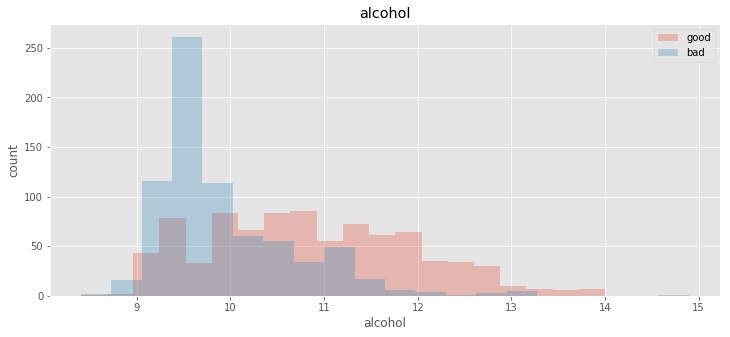

In [17]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [18]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [20]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [21]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [22]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [23]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [24]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [25]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [26]:
from sklearn.metrics.pairwise import euclidean_distances

Функция иницализации начальных центройдов методом 'k-means++'

In [27]:
def init_k(X, k):
    centroids = np.empty([k, X.shape[1]])
    centroids[0] = X[np.random.randint(X.shape[0])]
    
    for i in range(1, k):
        d = euclidean_distances(X, centroids[:i], squared = True)
        dist = d.min(axis = 1)
        #dist = np.array([np.array([np.linalg.norm(point - centr) for centr in centroids[:i,:]]).min() for point in X])
        summ = dist.sum()
        
        rnd = np.random.random_sample() * summ
        new_idx = np.searchsorted(np.cumsum(dist), rnd)
        
        centroids[i] = X[new_idx]
    
    return centroids

Функция иницализации начальных центройдов случайным методом

In [28]:
def init_random(X, k):
    random_elements = np.random.choice(np.arange(X.shape[0]), k, False)
    centroids = X[random_elements]
        
    while len(np.unique(centroids, axis = 0)) != k: 
        random_elements = np.random.choice(np.arange(X.shape[0]), k, False)
        centroids = X[random_elements]
    return centroids

Определение и вызов необходимого метода инициализации

In [29]:
def init_centroids(X, k, init):
    if init == 'k-means++':
        return init_k(X, k)
    elif init == 'random':
        return init_random(X, k)
    else:
        raise Exception("wrong init")

Проставление меток элементам из X по центройдам

In [30]:
def get_labels(X, centroids):
    
    dist = euclidean_distances(X, centroids)
    return np.array([np.argmin(distance) for distance in dist])

Kmeans и MiniBatch

In [31]:
from sklearn.base import ClusterMixin

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.init = init
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
    
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров 
        self.centroids = init_centroids(X, self.k, self.init)
        
        # Запоминаем старые центройды и начальные (для преждевременного выхода из цикла и анализа точности далее)
        old_centroids = self.centroids.copy()
        self.init_c = self.centroids.copy()
        
        ## Your Code Here
        for i in range(self.max_iter):
            
            # Следующая строчка - проставление меток без использования sclearn, очень долго (~1-2 мин)
            #self.labels = np.array([np.argmin([np.linalg.norm(point - centr) for centr in self.centroids]) for point in X])
            
            self.labels = get_labels(X, self.centroids)
            
            # Если есть пустой кластер, переносим центройд
            for k in range(self.k):
                if X[self.labels == k].size == 0:
                    new_center_id = np.argmax(X, axis = 0)[0]
                    self.centroids[k] = X[new_center_id]
                    self.labels[new_center_id] = k
            
            self.centroids = np.vstack([X[self.labels == k].mean(axis = 0) for k in range(self.k)])
            
            # Если центройды не изменились с предыдущего шага - выходим из цикла
            if (self.centroids == old_centroids).all():
                return self
            else:
                old_centroids = self.centroids.copy()
        
        return self
    
    def predict(self, X, y=None):
        
        return get_labels(X, self.centroids)
        
        #return np.array([np.argmin([np.linalg.norm(point - centr) for centr in self.centroids]) for point in X])

class MiniBatchKmeans(Kmeans):
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random', batch_size = 100):
        Kmeans.__init__ (self, k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    
    def fit(self, X, y=None):
        
        # Если элементов меньше, чем размер batch, то используем обычный Kmeans
        if X.shape[0] <= self.batch_size :
            return Kmeans(k=self.k, init=self.init).fit(X,y)
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров 
        self.centroids = init_centroids(X, self.k, self.init)
              
        # Масств с числом элементов в каждом кластере
        num_in_cluster = np.ones(self.k)

        for i in range(self.max_iter):
        
            batch = X[np.random.choice(np.arange(X.shape[0]), self.k, False)]
            
            labels = self.predict(batch)
            
            for center in range(self.k):
                
                self.centroids[center] = self.centroids[center] * num_in_cluster[center] + batch[labels == center].sum(axis = 0)
                num_in_cluster[center] += (labels == center).sum ()
                self.centroids[center] = self.centroids[center]/num_in_cluster[center]
        
        #self.labels = np.array([np.argmin([np.linalg.norm(point - centr) for centr in self.centroids]) for point in X])
        self.labels = get_labels(X, self.centroids)
        
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [32]:
from sklearn.datasets import make_blobs

In [33]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

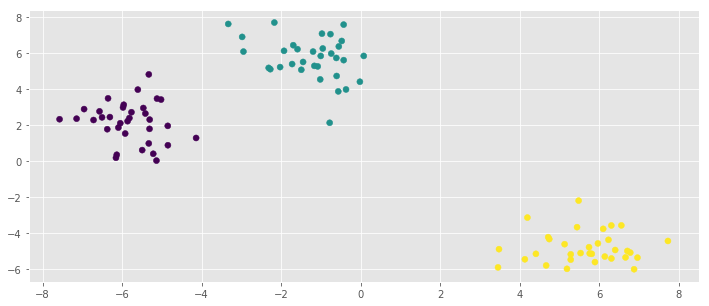

In [34]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

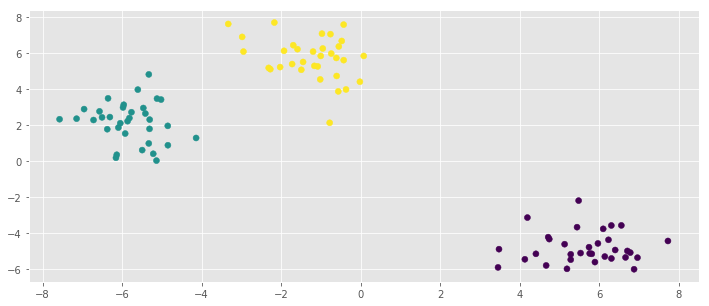

In [35]:
## Работоспособность KMeans
model = Kmeans(k=3).fit(X)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

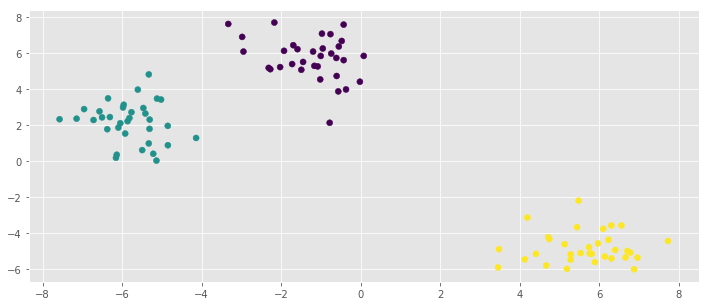

In [36]:
## Работоспособность KMeans++
model = Kmeans(k=3, init = 'k-means++').fit(X)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

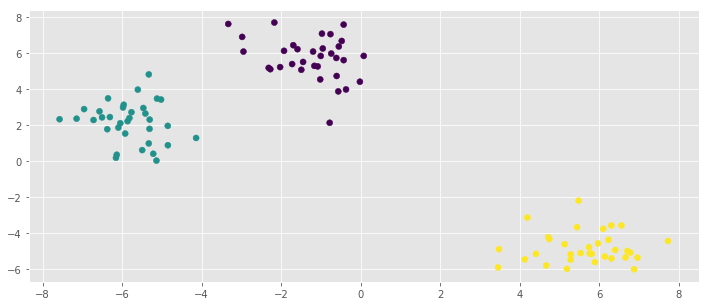

In [37]:
## Работоспособность KMeans с MiniBatchKMeans
model = MiniBatchKmeans(k=3).fit(X)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

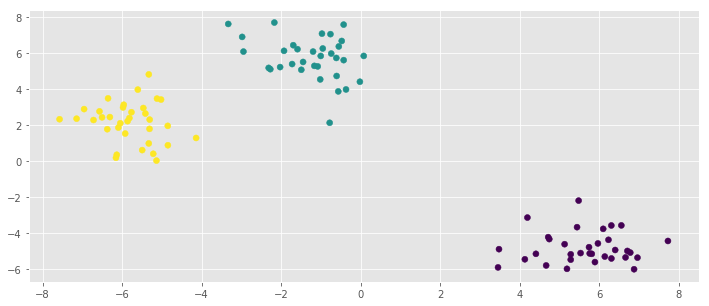

In [38]:
## Работоспособность KMeans++ с MiniBatchKMeans
model = MiniBatchKmeans(k=3, init = 'k-means++').fit(X)
plt.scatter(X[:,0], X[:, 1], c=model.labels)

In [39]:
## Время выполнения алгоритма KMeans

In [40]:
## Время выполнения алгоритма KMeans++

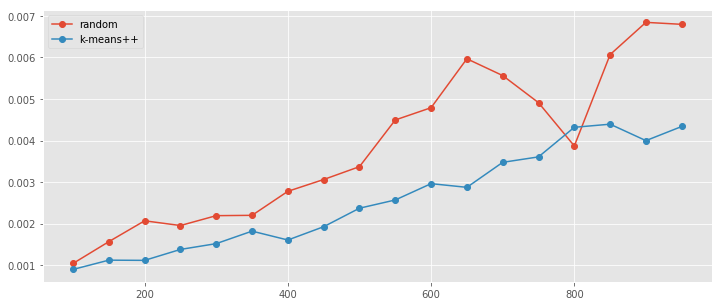

In [41]:
kmeans_results = np.empty(0)
for i in range(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    run_result = %timeit -o -q -n 10 Kmeans(k = 3).fit(X)
    kmeans_results = np.append(kmeans_results, run_result.best)

plt.plot(np.arange(100, 1000, 50), kmeans_results, marker = 'o', label = 'random')

kmeans_results = np.empty(0)
for i in range(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    run_result = %timeit -o -q -n 10 Kmeans(k = 3, init="k-means++").fit(X)
    kmeans_results = np.append(kmeans_results, run_result.best)

plt.plot(np.arange(100, 1000, 50), kmeans_results, marker = 'o', label = 'k-means++')

plt.legend()

In [42]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

In [43]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

График времени для MiniBatch показывает одно время, т.к. завершается после фиксированного числа итераций

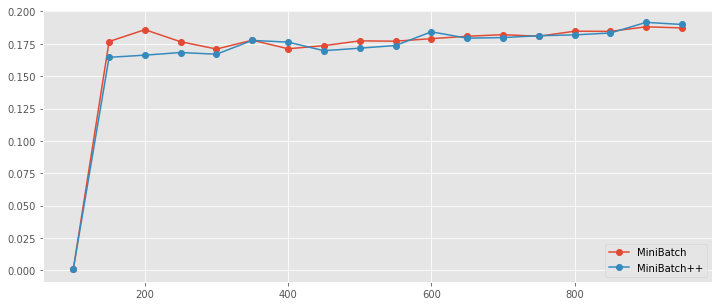

In [44]:
kmeans_results = np.empty(0)
for i in range(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    run_result = %timeit -o -q -n 1 MiniBatchKmeans(k=3).fit(X)
    kmeans_results = np.append(kmeans_results, run_result.best)

plt.plot(np.arange(100, 1000, 50), kmeans_results, marker = 'o', label = 'MiniBatch')

kmeans_results = np.empty(0)
for i in range(100, 1000, 50):
    X, y = make_blobs(n_samples=i, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    run_result = %timeit -o -q -n 1 MiniBatchKmeans(k=3, init="k-means++").fit(X)
    kmeans_results = np.append(kmeans_results, run_result.best)

plt.plot(np.arange(100, 1000, 50), kmeans_results, marker = 'o', label = 'MiniBatch++')

plt.legend()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [45]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

* Удалите все признаки кроме 36 ключевых слов.

In [46]:
df_croped = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1)
df_croped.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.

In [47]:
from sklearn.preprocessing import scale

In [48]:
df_norm = df_croped.apply(scale)
df_norm.head()

C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,...,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908
1,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,...,-0.050937,1.067392,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908
2,-0.332217,1.060049,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,...,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,2.027908,-0.220403,-0.174908
3,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,...,-0.050937,-0.369915,-0.487314,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,-0.220403,-0.174908
4,-0.332217,-0.357697,-0.242874,-0.217928,-0.22367,-0.259971,-0.207327,-0.201131,-0.168939,-0.297123,...,-0.050937,-0.369915,2.273673,-0.314198,-0.201476,-0.183032,-0.294793,-0.261530,2.285122,2.719316


* Используйте метод k-means чтобы выделить 9 кластеров

In [49]:
Data = df_norm.as_matrix()

In [50]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

Выполним реализованные методы на реальных данных и сравним их с методами из библиотеки sclearn.
Для этого запустим обе версии с одинаковыми начальными кластерами (берутся из реализованного метода) и вычислим Adjusted Rand index для полученных меток. Чем ближе полученное число к 1, тем точнее совпадение в кластерах

In [51]:
## KMeans
%time real_model = Kmeans(k=9).fit(Data)
%time kmeans_model = KMeans(n_clusters=9, init = real_model.init_c).fit(Data)
print adjusted_rand_score(real_model.labels, kmeans_model.labels_)

Wall time: 1.89 s


C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\cluster\k_means_.py:893: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


Wall time: 290 ms
0.999449384058


In [52]:
## KMeans++
%time real_model = Kmeans(k=9, init = 'k-means++').fit(Data)
%time kmeans_model = KMeans(n_clusters=9, init = real_model.init_c, n_jobs = 1).fit(Data)
print adjusted_rand_score(real_model.labels, kmeans_model.labels_)

Wall time: 2.37 s
Wall time: 301 ms
1.0


Для MiniBatch такое сравнение бессмысленно, т.к. алгоритм характеризуется не точностью, а скоростью

In [53]:
## KMeans с MiniBatchKMeans
%time real_model = MiniBatchKmeans(k=9).fit(Data)

Wall time: 1.05 s


In [54]:
## KMeans++ с MiniBatchKMeans
%time real_model = MiniBatchKmeans(k=3, init="k-means++").fit(Data)

Wall time: 1.02 s


* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)  
(см после вывода)

In [55]:
## Вывод

Из двух алгоритмов Kmeans и Kmeans++ лушим является второй. Предварительный выбор кластеров дает не только лушчую кластризацию, но и ускоряет время работы алгоритма, т.к. нужно меньше итераций.
MiniBatch может давать менее точную кластеризацию, но может быстро дать представление о данных. В этом алгоритме надо очень аккуратно выбирать число общих итераций. Возможно, имеет смысл его зависящим от размера данных и размера batch. Иначе на небольших данных алгоритм будет делать слишком много итераций и долго работать, а на больших данных - слишком мало и плохо кластеризовать. Реализация некого критерия выхода из цикла частично решит эту проблему.
Вывод: если точность важнее скорости, то Kmeans++ лучше, иначе - MiniBatch

Ниже анализ кластеров, полученных методом Kmeans++. Полученные изображения довольно красноречивы, так что сопровождаются лишь коротким комментарием

In [56]:
model = Kmeans(k=9, init='k-means++')
model.fit(Data)

Kmeans(init='k-means++', k=9, max_iter=1000, metric='euclidean',
    random_state=None)

Сформируем DataFrame, в который занесем среднее значение по каждому кластеру и построим гистограмму

In [57]:
res = pd.DataFrame()
for i in range(9):
    rows_in_cluster = df_sns.loc[model.labels==i]
    df_cluster = rows_in_cluster.mean().to_frame().T
    df_cluster['total'] = rows_in_cluster.shape[0]
    res = res.append(df_cluster)

Средние значения

In [58]:
res

,gradyear,age,friends,basketball,football,soccer,softball,volleyball,swimming,cheerleading,...,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs,total
0,2007.429979,18.159839,27.360912,0.112653,0.095064,0.109094,0.056791,0.066282,0.078403,0.047816,...,0.121061,0.172384,0.053747,0.015165,0.009594,0.122350,0.074122,0.051426,0.021097,19387
0,2007.714286,17.642650,33.132740,1.290571,1.315662,1.127074,0.187374,0.625658,0.167544,0.156617,...,0.235937,0.326993,0.124241,0.035613,0.014569,0.139620,0.089437,0.066370,0.030757,2471
0,2007.606987,17.629056,30.930131,0.551310,0.497817,0.311135,0.222707,0.211790,0.266376,0.192140,...,0.705240,0.533843,0.717249,0.131004,0.129913,1.306769,0.501092,0.842795,1.057860,916
0,2007.355844,18.119487,32.896104,0.177922,0.275325,0.144156,0.115584,0.090909,0.155844,0.054545,...,0.181818,0.294805,0.145455,0.011688,0.010390,0.171429,0.124675,0.053247,0.032468,770
0,2007.589060,17.843464,38.307153,0.638149,0.356241,0.232819,3.248247,0.402525,0.196353,0.088359,...,0.258065,0.472651,0.187938,0.056101,0.050491,0.159888,0.133240,0.064516,0.043478,713
0,2007.572717,17.757036,36.198613,0.235376,0.230983,0.177110,0.100578,0.126012,0.289480,0.280925,...,0.680925,0.985202,0.386358,0.052023,0.030058,0.243006,0.209249,0.104509,0.047399,4325
0,2007.793103,17.247988,36.046552,0.372414,0.381034,0.339655,0.158621,0.248276,0.213793,0.217241,...,0.532759,0.612069,0.318966,0.087931,0.068966,0.222414,0.129310,0.117241,0.062069,580
0,2007.850657,17.503384,41.316607,0.377539,0.395460,0.308244,0.162485,0.266428,0.259259,0.314217,...,0.677419,0.921147,0.413381,1.516129,1.170848,0.211470,0.158901,0.111111,0.074074,837
0,2007.000000,18.119000,44.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,6.000000,6.000000,0.000000,1


Самый большой кластер - обычные студенты, любящие музыку

19387.0


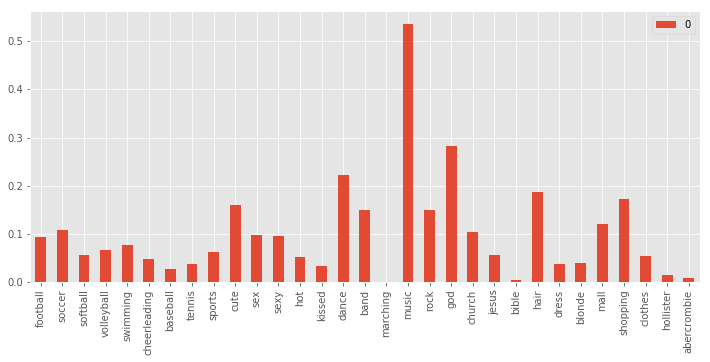

In [59]:
res.iloc[0:1,4:35].T.plot.bar()
print res.iloc[0]['total']

Спортсмены

2471.0


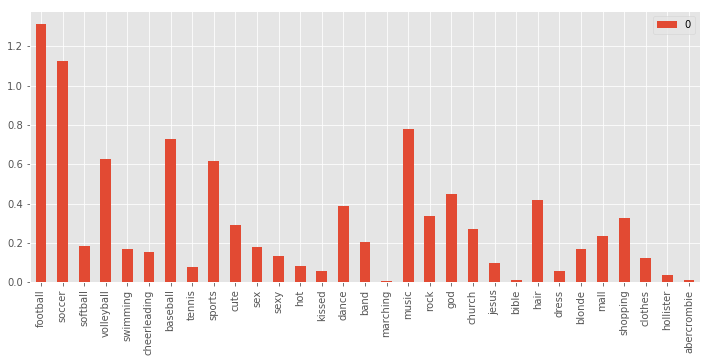

In [60]:
res.iloc[1:2,4:35].T.plot.bar()
print res.iloc[1]['total']

Люди, которым не важно, что у тебя внутри

916.0


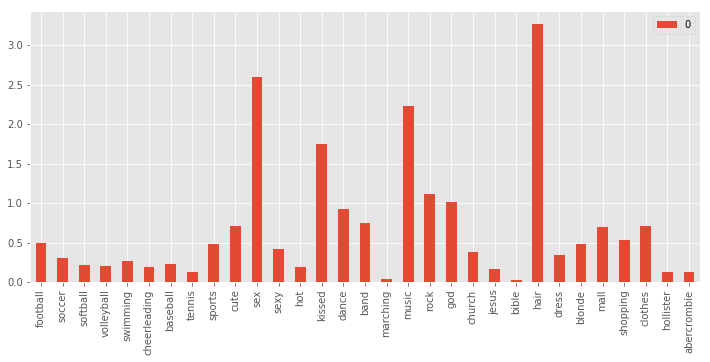

In [61]:
res.iloc[2:3,4:35].T.plot.bar()
print res.iloc[2]['total']

Музыканты

770.0


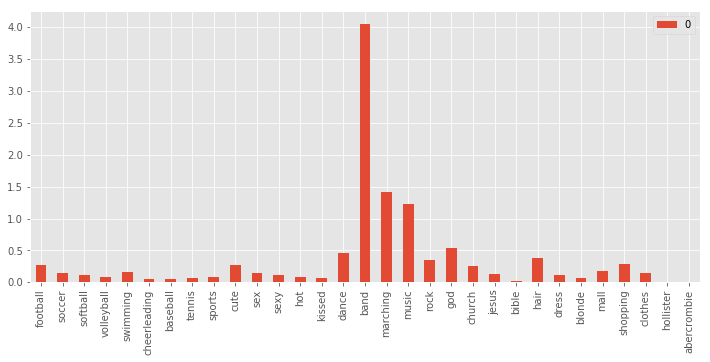

In [62]:
res.iloc[3:4,4:35].T.plot.bar()
print res.iloc[3]['total']

Игроки в софтбол и теннис

713.0


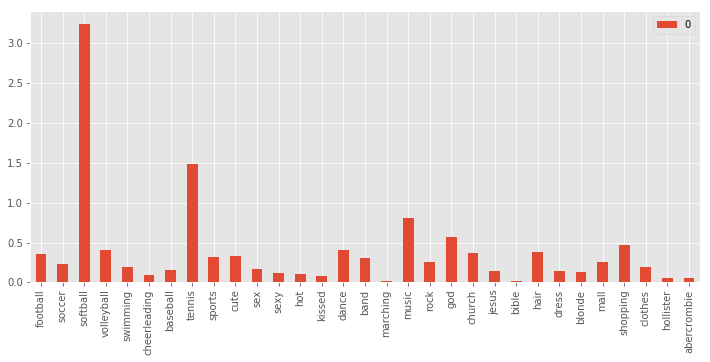

In [63]:
res.iloc[4:5,4:35].T.plot.bar()
print res.iloc[4]['total']

Довольно большой кластер. Наложение верующих и людей, любящих потусить

4325.0


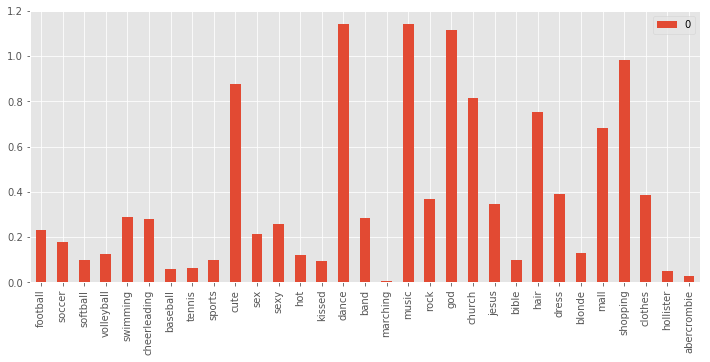

In [64]:
res.iloc[5:6,4:35].T.plot.bar()
print res.iloc[5]['total']

Видимо, люди, которые считают себя очень привлекательными

580.0


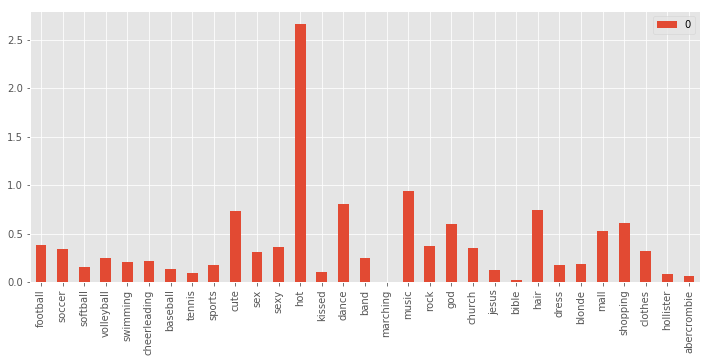

In [65]:
res.iloc[6:7,4:35].T.plot.bar()
print res.iloc[6]['total']

Любители шоппинга и модных вещей

837.0


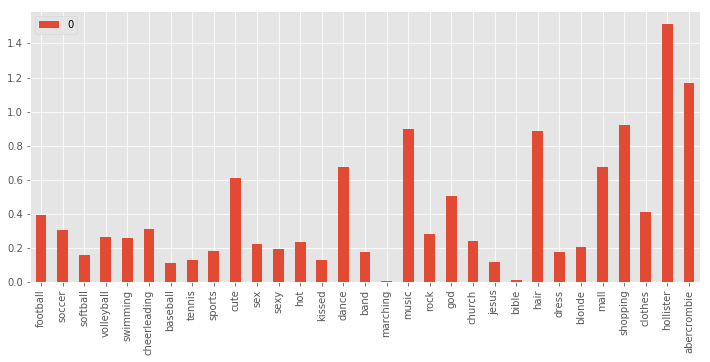

In [66]:
res.iloc[7:8,4:35].T.plot.bar()
print res.iloc[7]['total']

Одна аномальная запись - поле 'blonde' больше 300

1.0


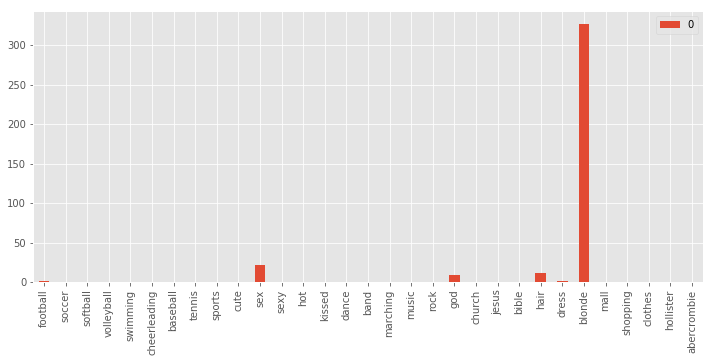

In [67]:
res.iloc[8:9,4:35].T.plot.bar()
print res.iloc[8]['total']